In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, RepeatVector, Concatenate, Dense, TimeDistributed, Attention
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import random
from transformers import MarianMTModel, MarianTokenizer

In [9]:
# Load and preprocess data
url = '/kaggle/input/eng-french/eng_-french.csv' 
data = pd.read_csv(url)
data.rename(columns={"English words/sentences": "Eng", "French words/sentences": "Frn"}, inplace=True)
french_sentences = data['Frn'].tolist()


In [10]:
def tokenize_and_pad(texts, max_len=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded_sequences, tokenizer

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'])
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'])

eng_max_len = max(len(seq) for seq in eng_sequences)
frn_max_len = max(len(seq) for seq in frn_sequences)

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'], max_len=eng_max_len)
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'], max_len=frn_max_len)

eng_vocab_size = len(eng_tokenizer.word_index) + 1
frn_vocab_size = len(frn_tokenizer.word_index) + 1

train_eng, test_eng, train_frn, test_frn = train_test_split(eng_sequences, frn_sequences, test_size=0.2, random_state=42)



In [15]:
def define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim=128, lstm_units=256):
    # Encoder
    encoder_inputs = Input(shape=(eng_max_len,))
    encoder_embedding = Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_len, mask_zero=True)(encoder_inputs)
    
    # Bidirectional LSTM layer with return_state=True
    encoder_lstm = Bidirectional(LSTM(units=lstm_units, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5, use_bias=True, kernel_initializer='glorot_uniform'))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    
    # Concatenate forward and backward hidden states
    context_vector = Concatenate()([forward_h, backward_h])  # Shape: (batch_size, lstm_units * 2)
    
    # Repeat the context vector for each timestep in the decoder
    decoder_inputs = RepeatVector(frn_max_len)(context_vector)  # Shape: (batch_size, frn_max_len, lstm_units * 2)

    # Decoder
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs)
    decoder_dense = TimeDistributed(Dense(frn_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model(encoder_inputs, decoder_outputs)
    
    # Compile the model
    initial_learning_rate = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.5,
        staircase=True
    )
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
440/440 ━━━━━━━━━━━━━━━━━━━━ 211s 461ms/step - accuracy: 1.0000 - loss: 0.2977 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 2/3
440/440 ━━━━━━━━━━━━━━━━━━━━ 202s 459ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 3/3
440/440 ━━━━━━━━━━━━━━━━━━━━ 202s 458ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0040


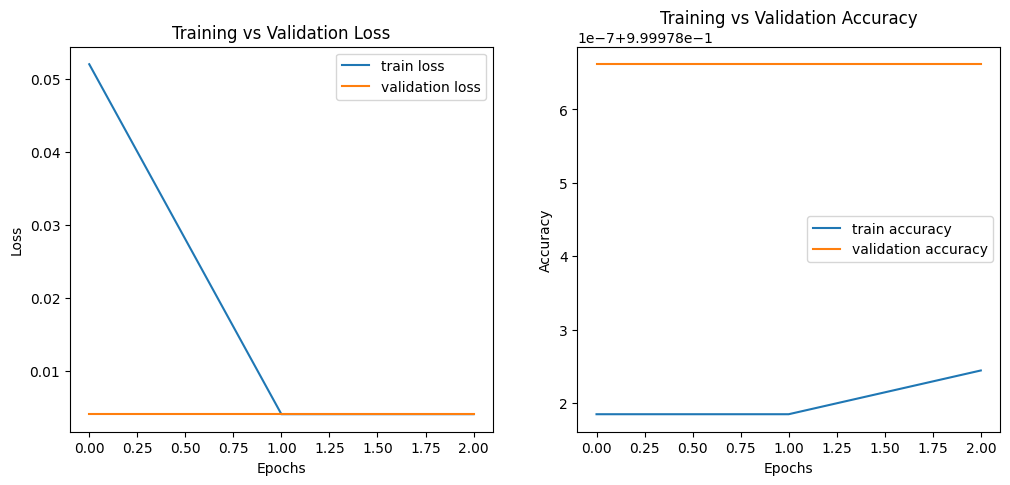

In [16]:
embedding_dim = 128
lstm_units = 256
batch_size = 256
epochs = 3

# Get only the model to train
model = define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim, lstm_units)

# Prepare data for the decoder
train_frn_input = train_frn[:, :-1]  # input 
train_frn_output = train_frn[:, 1:]  # expected output 

# Padding train_frn_input to ensure it matches the required input shape
train_frn_input = pad_sequences(train_frn_input, maxlen=frn_max_len, padding='post')
train_frn_output = pad_sequences(train_frn_output, maxlen=frn_max_len, padding='post')

# Train the model
history = model.fit(train_eng, train_frn_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

plt.show()

In [32]:
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 20, 128)   │  4,736,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 20)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 20, 512), │    788,480 │ embedding_6[0][0… │
│ (Bidirectional)     │ (None, 256),      │            │ not_equal_6[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 20, 512)   │          0 │ concatenate[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 20, 512), │  2,099,200 │ repeat_vector[0]… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 20, 37000) │ 18,981,000 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,814,041 (304.47 MB)

 Trainable params: 26,604,680 (101.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,209,361 (202.98 MB)

In [37]:
def create_encoder_model(eng_max_len, embedding_dim, lstm_units, eng_vocab_size):
    encoder_inputs = Input(shape=(eng_max_len,))
    encoder_embedding = Embedding(eng_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(units=lstm_units, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5))(encoder_embedding)
    forward_h, forward_c, backward_h, backward_c = encoder_lstm[1:5]
    context_vector = Concatenate()([forward_h, backward_h])
    
    encoder_model = Model(encoder_inputs, [context_vector, forward_h, forward_c])
    return encoder_model

def create_decoder_model(frn_max_len, embedding_dim, lstm_units, frn_vocab_size):
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(frn_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding)
    decoder_dense = TimeDistributed(Dense(frn_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model(decoder_inputs, decoder_outputs)
    return decoder_model

def set_weights_from_trained_model(trained_model, encoder_model, decoder_model):
    # Extract weights from the trained model
    encoder_embedding_weights = trained_model.get_layer('embedding_6').get_weights()
    encoder_lstm_weights = trained_model.get_layer('bidirectional').get_weights()
    decoder_lstm_weights = trained_model.get_layer('lstm_7').get_weights()
    decoder_dense_weights = trained_model.get_layer('time_distributed').get_weights()
    
    # Set weights for the encoder model
    encoder_model.get_layer('embedding_6').set_weights(encoder_embedding_weights)
    encoder_model.get_layer('bidirectional').set_weights(encoder_lstm_weights)
    
    # Set weights for the decoder model
    decoder_model.get_layer('embedding').set_weights(encoder_embedding_weights)  # Re-use the encoder embedding weights
    decoder_model.get_layer('lstm_7').set_weights(decoder_lstm_weights)
    decoder_model.get_layer('time_distributed').set_weights(decoder_dense_weights)

# Define encoder and decoder models
encoder_model = create_encoder_model(eng_max_len, embedding_dim, lstm_units, eng_vocab_size)
decoder_model = create_decoder_model(frn_max_len, embedding_dim, lstm_units, frn_vocab_size)

# Set weights from the trained model
set_weights_from_trained_model(model, encoder_model, decoder_model)

# Translate a sentence using the updated models
input_sentence = "Hello, how are you?"
translation = translate_sentence(input_sentence, eng_tokenizer, frn_tokenizer, encoder_model, decoder_model, eng_max_len, frn_max_len)
print(f"Input sentence: {input_sentence}")
print(f"Translated sentence: {translation}")



ValueError: No such layer: embedding_6. Existing layers are: ['input_layer_18', 'embedding_18', 'bidirectional_6', 'concatenate_7'].

In [29]:
def translate_sentence(input_sentence, eng_tokenizer, frn_tokenizer, encoder_model, decoder_model, eng_max_len, frn_max_len):
    # Tokenize and pad the input sentence
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len, padding='post')
    
    # Encode the input sentence
    context_vector, enc_h, enc_c = encoder_model.predict(input_seq)
    
    # Initialize the decoder with the context vector
    target_seq = np.zeros((1, 1))  # Start token
    target_seq[0, 0] = frn_tokenizer.word_index.get('startseq', 0)
    
    decoded_words = []
    
    for _ in range(frn_max_len):
        output_tokens = decoder_model.predict(target_seq)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = frn_tokenizer.index_word.get(sampled_token_index, '')
        
        if sampled_word == 'endseq':
            break
        
        decoded_words.append(sampled_word)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
    
    return ' '.join(decoded_words)
input_sentence = "Hello, how are you?"
translation = translate_sentence(input_sentence, eng_tokenizer, frn_tokenizer, encoder_model, decoder_model, eng_max_len, frn_max_len)
print(f"Input sentence: {input_sentence}")
print(f"Translated sentence: {translation}")


ValueError: No such layer: embedding. Existing layers are: ['input_layer_6', 'embedding_6', 'bidirectional', 'concatenate', 'repeat_vector', 'lstm_7', 'time_distributed'].

In [20]:
# Define and compile the inference models
encoder_model, decoder_model = create_inference_models(model, eng_max_len, frn_max_len, embedding_dim, lstm_units, frn_vocab_size)

# Example of translating a sentence
input_sentence = "Hello, how are you?"
translated_sentence = translate_sentence(input_sentence, eng_tokenizer, frn_tokenizer, encoder_model, decoder_model, eng_max_len, frn_max_len)
print(f"Translated Sentence: {translated_sentence}")


ValueError: You called `set_weights(weights)` on layer 'functional_9' with a weight list of length 6, but the layer was expecting 7 weights.